In [278]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

In [279]:
airports = pd.read_csv("data/Airports Data.csv")
bag_level = pd.read_csv("data/Bag+Level+Data.csv")
flight_level = pd.read_csv("data/Flight Level Data.csv")
pnr_remark_level = pd.read_csv("data/PNR Remark Level Data.csv")
pnr_flight_level = pd.read_csv("data/PNR+Flight+Level+Data.csv")


In [280]:
# Drop flights with invalid ground times
invalid = (flight_level['scheduled_ground_time_minutes'] <= 0).sum()
print(f"Dropping {invalid} flights with negative ground times")

flight_level = flight_level[flight_level['scheduled_ground_time_minutes'] >= 0].copy()

Dropping 312 flights with negative ground times


In [281]:
# Convert datetime columns
flight_level['scheduled_departure_datetime_local'] = pd.to_datetime(
    flight_level['scheduled_departure_datetime_local']
)
flight_level['actual_departure_datetime_local'] = pd.to_datetime(
    flight_level['actual_departure_datetime_local']
)
flight_level['scheduled_arrival_datetime_local'] = pd.to_datetime(
    flight_level['scheduled_arrival_datetime_local']
)
flight_level['scheduled_departure_date_local'] = pd.to_datetime(
    flight_level['scheduled_departure_date_local']
)


In [282]:
# 1. Remove time travel flights (arrival before departure)
time_travel = (flight_level['actual_arrival_datetime_local'] < flight_level['actual_departure_datetime_local']).sum()
print(f"Dropping {time_travel:,} time travel flights (arrival before departure)")
flight_level = flight_level[flight_level['actual_arrival_datetime_local'] >= flight_level['actual_departure_datetime_local']].copy()

# 2. Calculate delay if not already present
if 'delay_minutes' not in flight_level.columns:
    flight_level['delay_minutes'] = (
        flight_level['actual_departure_datetime_local'] - 
        flight_level['scheduled_departure_datetime_local']
    ).dt.total_seconds() / 60

# 3. Remove extreme delays (> 24 hours)
extreme_delays = (flight_level['delay_minutes'] > 1440).sum()
print(f"Dropping {extreme_delays:,} flights with extreme delays (>24 hours)")
flight_level = flight_level[flight_level['delay_minutes'] <= 1440].copy()

# 4. Calculate scheduled duration
flight_level['scheduled_duration_minutes'] = (
    flight_level['scheduled_arrival_datetime_local'] - 
    flight_level['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

# 5. Remove impossible flight durations
too_short = (flight_level['scheduled_duration_minutes'] < 15).sum()
too_long = (flight_level['scheduled_duration_minutes'] > 1200).sum()
print(f"Dropping {too_short:,} flights with duration <15 minutes")
print(f"Dropping {too_long:,} flights with duration >20 hours")
flight_level = flight_level[
    (flight_level['scheduled_duration_minutes'] >= 15) & 
    (flight_level['scheduled_duration_minutes'] <= 1200)
].copy()

# 6. Remove flights with same origin and destination
same_airport = (flight_level['scheduled_departure_station_code'] == flight_level['scheduled_arrival_station_code']).sum()
print(f"Dropping {same_airport:,} flights with same departure and arrival airport")
flight_level = flight_level[flight_level['scheduled_departure_station_code'] != flight_level['scheduled_arrival_station_code']].copy()



Dropping 0 time travel flights (arrival before departure)
Dropping 0 flights with extreme delays (>24 hours)
Dropping 17 flights with duration <15 minutes
Dropping 16 flights with duration >20 hours
Dropping 0 flights with same departure and arrival airport


In [283]:
# Remove duplicates based on scheduled_departure and flight_number
before_flight = len(flight_level)
flight_level = flight_level.drop_duplicates(subset=['scheduled_departure_datetime_local', 'flight_number'], keep='first')
print(f"Removed {before_flight - len(flight_level)} duplicate rows based on scheduled_departure_datetime_local + flight_number")

# Remove fleet_type column
if 'fleet_type' in flight_level.columns:
    flight_level = flight_level.drop(columns=['fleet_type'])
    print("Removed 'fleet_type' column")
    
# Remove true duplicates 
before_true_dup = len(flight_level)
flight_level = flight_level.drop_duplicates()

Removed 9 duplicate rows based on scheduled_departure_datetime_local + flight_number
Removed 'fleet_type' column


EDA Question 1: Delay Analysis

In [284]:
# Calculate delay in minutes
flight_level['delay_minutes'] = (
    flight_level['actual_departure_datetime_local'] - 
    flight_level['scheduled_departure_datetime_local']
).dt.total_seconds() / 60

flight_level['status'] = flight_level['delay_minutes'].apply(
    lambda x: 'On-time' if x <= 0 else 'Delayed'
)

# Separate metrics for clarity
avg_delay_all = flight_level['delay_minutes'].mean()
avg_delay_delayed_only = flight_level[flight_level['delay_minutes'] > 0]['delay_minutes'].mean()

delayed_flights = (flight_level['delay_minutes'] > 0).sum()
early_flights = (flight_level['delay_minutes'] < 0).sum()
ontime_flights = (flight_level['delay_minutes'] == 0).sum()

pct_delayed = (delayed_flights / len(flight_level)) * 100
pct_early = (early_flights / len(flight_level)) * 100

print(f"Overall average (including early): {avg_delay_all:.2f} minutes")
print(f"Average delay (delayed flights only): {avg_delay_delayed_only:.2f} minutes")
print(f"")
print(f"Delayed flights: {delayed_flights:,} ({pct_delayed:.2f}%)")
print(f"Early flights: {early_flights:,} ({pct_early:.2f}%)")
print(f"On-time flights: {ontime_flights:,}")

Overall average (including early): 17.22 minutes
Average delay (delayed flights only): 40.75 minutes

Delayed flights: 3,705 (47.79%)
Early flights: 3,718 (47.96%)
On-time flights: 329


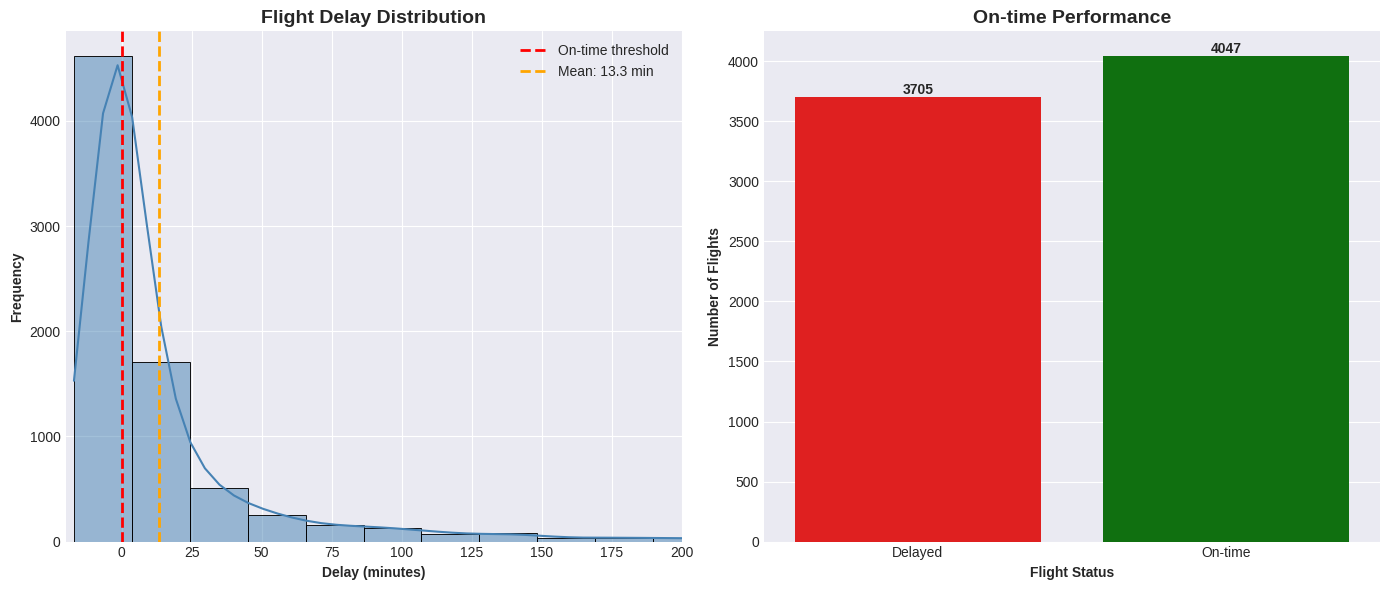

In [285]:
# Visualization: Delay Distribution (clean + warning-free)
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# 1. Distribution plot with KDE
sns.histplot(
    data=flight_level, 
    x='delay_minutes', 
    bins=50, 
    kde=True, 
    color='steelblue', 
    ax=axes[0]
)
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='On-time threshold')
axes[0].axvline(x=avg_delay, color='orange', linestyle='--', linewidth=2, 
                label=f'Mean: {avg_delay:.1f} min')

# Limit x-axis for better visibility
axes[0].set_xlim(-20, 200)
axes[0].set_xlabel('Delay (minutes)', fontweight='bold')
axes[0].set_ylabel('Frequency', fontweight='bold')
axes[0].set_title('Flight Delay Distribution', fontsize=14, fontweight='bold')
axes[0].legend()

# 2. Count plot for on-time vs delayed (no warning)
sns.countplot(
    data=flight_level, 
    x='status', 
    hue='status', 
    palette={'On-time': 'green', 'Delayed': 'red'}, 
    legend=False, 
    ax=axes[1]
)

axes[1].set_xlabel('Flight Status', fontweight='bold')
axes[1].set_ylabel('Number of Flights', fontweight='bold')
axes[1].set_title('On-time Performance', fontsize=14, fontweight='bold')

# Add counts on bars
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()


EDA Question 2: Ground Time Analysis

Average ground time ratio: 4.18x minimum
Flights with tight turnaround (≤1.1x min): 463 (5.97%)


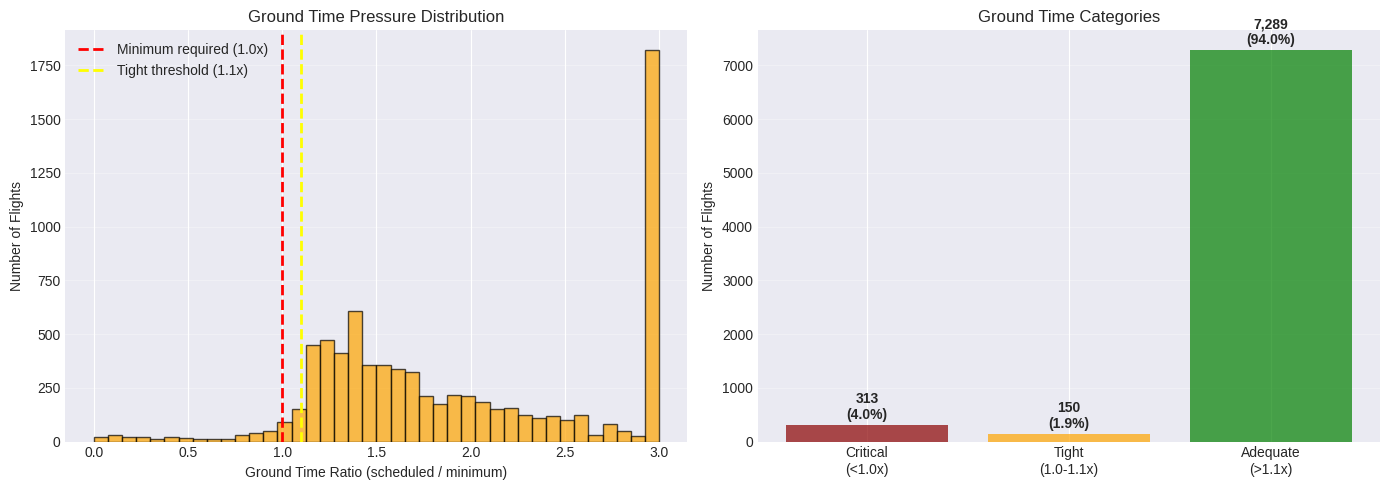

In [286]:
# Calculate ground time ratio
flight_level['ground_time_ratio'] = (
    flight_level['scheduled_ground_time_minutes'] / 
    flight_level['minimum_turn_minutes']
)

tight_turnaround = (flight_level['ground_time_ratio'] <= 1.1).sum()
pct_tight = (tight_turnaround / len(flight_level)) * 100

print(f"Average ground time ratio: {flight_level['ground_time_ratio'].mean():.2f}x minimum")
print(f"Flights with tight turnaround (≤1.1x min): {tight_turnaround:,} ({pct_tight:.2f}%)")

# Visualization: Ground Time Distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Ground time ratio distribution
axes[0].hist(flight_level['ground_time_ratio'].clip(upper=3), bins=40, 
            edgecolor='black', alpha=0.7, color='orange')
axes[0].axvline(x=1.0, color='red', linestyle='--', linewidth=2, 
               label='Minimum required (1.0x)')
axes[0].axvline(x=1.1, color='yellow', linestyle='--', linewidth=2, 
               label='Tight threshold (1.1x)')
axes[0].set_xlabel('Ground Time Ratio (scheduled / minimum)')
axes[0].set_ylabel('Number of Flights')
axes[0].set_title('Ground Time Pressure Distribution')
axes[0].legend()
axes[0].grid(axis='y', alpha=0.3)

# Tight vs Adequate turnaround
turnaround_categories = ['Critical\n(<1.0x)', 'Tight\n(1.0-1.1x)', 'Adequate\n(>1.1x)']
turnaround_counts = [
    (flight_level['ground_time_ratio'] < 1.0).sum(),
    ((flight_level['ground_time_ratio'] >= 1.0) & 
     (flight_level['ground_time_ratio'] <= 1.1)).sum(),
    (flight_level['ground_time_ratio'] > 1.1).sum()
]
colors = ['darkred', 'orange', 'green']
axes[1].bar(turnaround_categories, turnaround_counts, color=colors, alpha=0.7)
axes[1].set_ylabel('Number of Flights')
axes[1].set_title('Ground Time Categories')
axes[1].grid(axis='y', alpha=0.3)
for i, v in enumerate(turnaround_counts):
    axes[1].text(i, v + 50, f'{v:,}\n({v/len(flight_level)*100:.1f}%)', 
                ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

EDA Question 3: Baggage Analysis

In [287]:
# Aggregate bag data by flight
bag_summary = bag_level.groupby(
    ['company_id', 'flight_number', 'scheduled_departure_date_local', 
     'scheduled_departure_station_code', 'scheduled_arrival_station_code']
).agg(
    total_bags=('bag_tag_unique_number', 'count'),
    transfer_bags=('bag_type', lambda x: x.isin(['Transfer', 'Hot Transfer']).sum())
).reset_index()

bag_summary['checked_bags'] = bag_summary['total_bags'] - bag_summary['transfer_bags']
bag_summary['transfer_ratio'] = bag_summary['transfer_bags'] / bag_summary['total_bags']

print(f"Average bags per flight: {bag_summary['total_bags'].mean():.1f}")
print(f"Average transfer ratio: {bag_summary['transfer_ratio'].mean():.2%}")


Average bags per flight: 63.3
Average transfer ratio: 68.15%


In [288]:
bag_summary.head(5)

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,total_bags,transfer_bags,checked_bags,transfer_ratio
0,4Y,52,2025-08-08,ORD,MSP,1,1,0,1.0
1,9X,305,2025-08-01,ORD,PIT,1,1,0,1.0
2,9X,305,2025-08-08,ORD,PIT,1,1,0,1.0
3,9X,330,2025-08-03,ORD,IAD,1,1,0,1.0
4,9X,332,2025-08-01,ORD,IAD,1,1,0,1.0


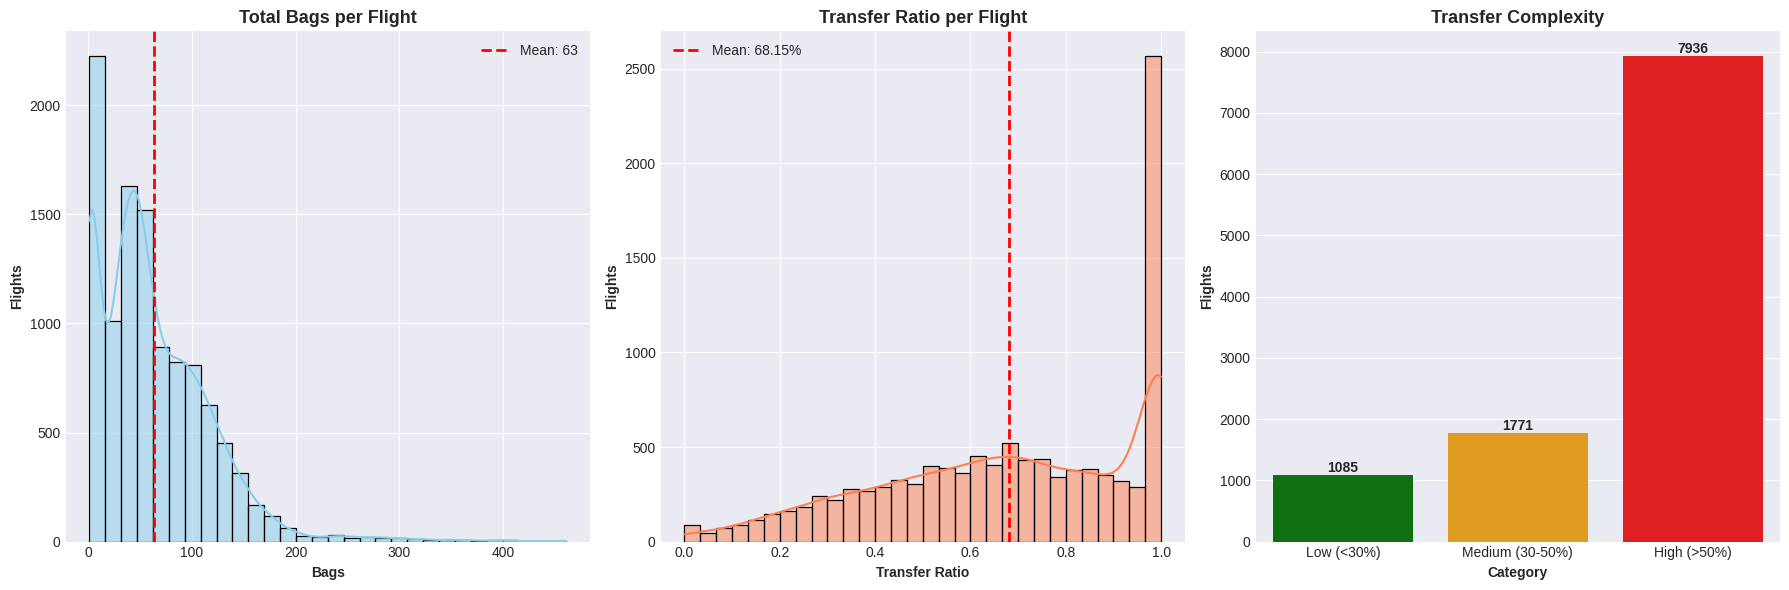

In [289]:
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# 1️⃣ Total Bags per Flight
sns.histplot(bag_summary['total_bags'], bins=30, kde=True, color='skyblue', ax=axes[0])
axes[0].axvline(bag_summary['total_bags'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {bag_summary["total_bags"].mean():.0f}')
axes[0].set_title('Total Bags per Flight', fontsize=13, fontweight='bold')
axes[0].set_xlabel('Bags', fontweight='bold')
axes[0].set_ylabel('Flights', fontweight='bold')
axes[0].legend()

# 2️⃣ Transfer Ratio Distribution
sns.histplot(bag_summary['transfer_ratio'], bins=30, kde=True, color='coral', ax=axes[1])
axes[1].axvline(bag_summary['transfer_ratio'].mean(), color='red', linestyle='--', linewidth=2,
                label=f'Mean: {bag_summary["transfer_ratio"].mean():.2%}')
axes[1].set_title('Transfer Ratio per Flight', fontsize=13, fontweight='bold')
axes[1].set_xlabel('Transfer Ratio', fontweight='bold')
axes[1].set_ylabel('Flights', fontweight='bold')
axes[1].legend()

# 3️⃣ Transfer Complexity Categories
bag_summary['transfer_category'] = pd.cut(
    bag_summary['transfer_ratio'],
    bins=[0, 0.3, 0.5, 1.0],
    labels=['Low (<30%)', 'Medium (30-50%)', 'High (>50%)']
)

sns.countplot(
    data=bag_summary, 
    x='transfer_category', 
    hue='transfer_category', 
    palette={'Low (<30%)': 'green', 'Medium (30-50%)': 'orange', 'High (>50%)': 'red'},
    legend=False,
    ax=axes[2]
)
axes[2].set_title('Transfer Complexity', fontsize=13, fontweight='bold')
axes[2].set_xlabel('Category', fontweight='bold')
axes[2].set_ylabel('Flights', fontweight='bold')

# Add labels on bars
for container in axes[2].containers:
    axes[2].bar_label(container, fmt='%d', fontweight='bold')

plt.tight_layout()
plt.show()

EDA Question 4: Passenger Load Analysis

In [290]:
unique_pnrs = pnr_flight_level.drop_duplicates(subset=['company_id', 'flight_number', 'scheduled_departure_date_local', 'record_locator'])
passenger_load = unique_pnrs.groupby(['company_id', 'flight_number', 'scheduled_departure_date_local'])['total_pax'].sum().reset_index()
passenger_load = passenger_load.rename(columns={'total_pax': 'total_passengers'})

In [291]:
passenger_load.sample(5)

,company_id,flight_number,scheduled_departure_date_local,total_passengers
546,G7,4530,2025-08-01,49
6082,UA,2038,2025-08-08,117
2661,OO,5810,2025-08-08,45
5728,UA,1851,2025-08-01,126
3184,UA,310,2025-08-06,117


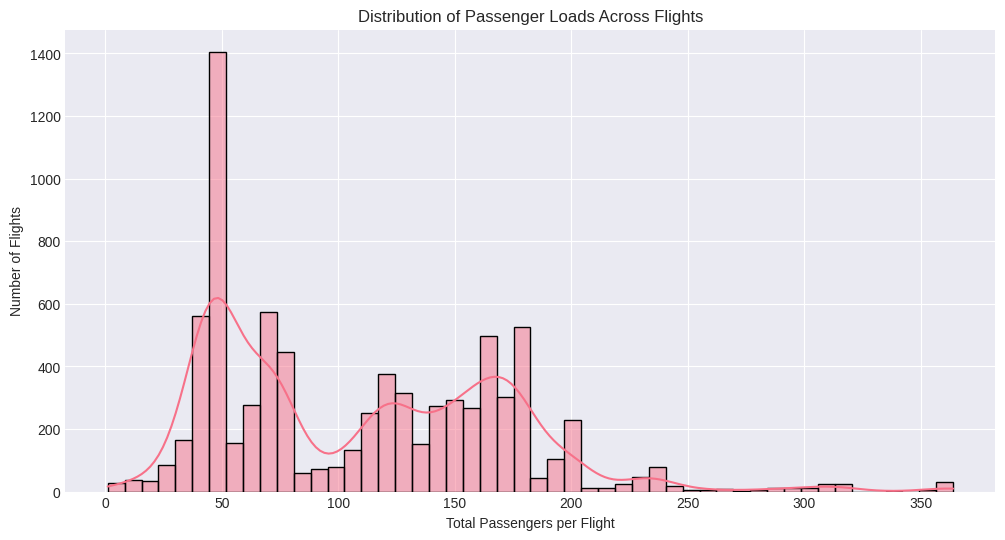

In [292]:
plt.figure(figsize=(12, 6))
sns.histplot(passenger_load['total_passengers'], bins=50, kde=True)
plt.title('Distribution of Passenger Loads Across Flights')
plt.xlabel('Total Passengers per Flight')
plt.ylabel('Number of Flights')
plt.grid(True)
plt.show()

In [293]:
passenger_load['scheduled_departure_date_local'] = pd.to_datetime(passenger_load['scheduled_departure_date_local'])
flight_level['scheduled_departure_date_local'] = pd.to_datetime(flight_level['scheduled_departure_date_local'])


Correlation between Load Factor and Departure Delay (for delayed flights): -0.25


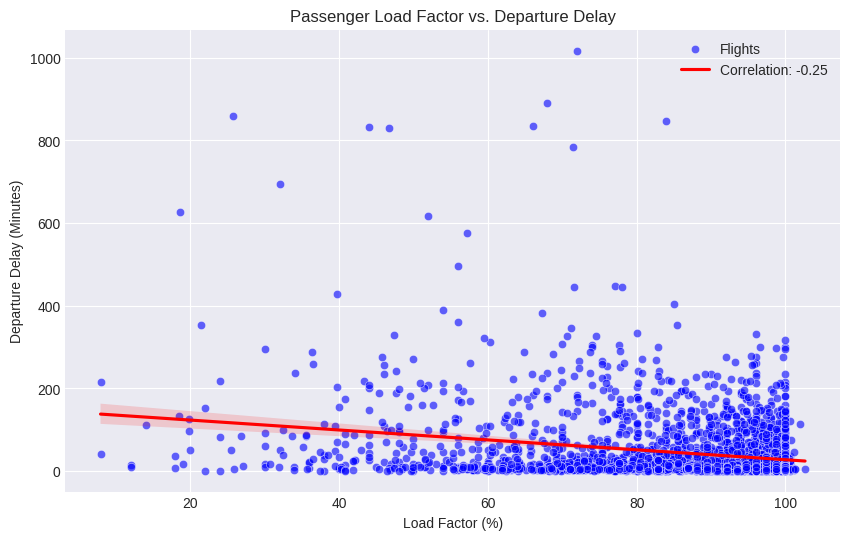

In [294]:
flight_data = pd.merge(passenger_load, flight_level, on=['company_id', 'flight_number', 'scheduled_departure_date_local'])

#  Load Factor (%)
flight_data['load_factor'] = (flight_data['total_passengers'] / flight_data['total_seats']) * 100

# Departure Delay in Minutes
flight_data['delay_minutes'] = (flight_data['actual_departure_datetime_local'] - flight_data['scheduled_departure_datetime_local']).dt.total_seconds() / 60

# finding correlation between Load Factor(higher loads) with Departure Delay(operational difficulty)
delayed_flights = flight_data[flight_data['delay_minutes'] > 0]
correlation = delayed_flights['load_factor'].corr(delayed_flights['delay_minutes'])
print(f"\nCorrelation between Load Factor and Departure Delay (for delayed flights): {correlation:.2f}")

# Visualize the relationship
plt.figure(figsize=(10, 6))

# Scatter plot
sns.scatterplot(
    x='load_factor',
    y='delay_minutes',
    data=delayed_flights,
    color='blue',
    alpha=0.6,
    label='Flights'
)

# Regression line (add label here instead)
sns.regplot(
    x='load_factor',
    y='delay_minutes',
    data=delayed_flights,
    scatter=False,
    color='red',
    label=f'Correlation: {correlation:.2f}'
)

plt.title('Passenger Load Factor vs. Departure Delay')
plt.xlabel('Load Factor (%)')
plt.ylabel('Departure Delay (Minutes)')
plt.legend()
plt.grid(True)
plt.show()

In [127]:
delayed_flights.sample(5)

,company_id,flight_number,scheduled_departure_date_local,total_passengers,scheduled_departure_station_code,scheduled_arrival_station_code,scheduled_departure_datetime_local,scheduled_arrival_datetime_local,actual_departure_datetime_local,actual_arrival_datetime_local,total_seats,carrier,scheduled_ground_time_minutes,actual_ground_time_minutes,minimum_turn_minutes,delay_minutes,status,ground_time_ratio,load_factor,departure_delay_minutes
1763,OO,5382,2025-08-01,42,ORD,FWA,2025-08-01 15:35:00+00:00,2025-08-01 17:47:00+00:00,2025-08-01 15:36:00+00:00,2025-08-01T17:40:00Z,50,Express,79,87,29,1.0,Delayed,2.724138,84.000000,1.0
5263,UA,1756,2025-08-15,154,ORD,YYZ,2025-08-15 21:14:00+00:00,2025-08-15 23:58:00+00:00,2025-08-15 21:33:00+00:00,2025-08-16T00:11:00Z,166,Mainline,54,80,65,19.0,Delayed,0.830769,92.771084,19.0
4841,UA,1525,2025-08-12,125,ORD,AUS,2025-08-12 13:40:00+00:00,2025-08-12 16:30:00+00:00,2025-08-12 13:45:00+00:00,2025-08-12T16:50:00Z,126,Mainline,60,79,43,5.0,Delayed,1.395349,99.206349,5.0
316,G7,4463,2025-08-09,32,ORD,ABE,2025-08-09 18:35:00+00:00,2025-08-09 21:55:00+00:00,2025-08-09 18:49:00+00:00,2025-08-09T21:52:00Z,50,Express,94,82,29,14.0,Delayed,3.241379,64.000000,14.0
7702,YX,3696,2025-08-01,55,ORD,CVG,2025-08-01 12:55:00+00:00,2025-08-01 15:21:00+00:00,2025-08-01 14:24:00+00:00,2025-08-01T16:39:00Z,70,Express,50,56,34,89.0,Delayed,1.470588,78.571429,89.0


EDA Question 5: Special Service Requests

Removed 126 extreme outlier flights (delay > 200 min)

AVERAGE DELAY BY LOAD FACTOR AND SSR LEVEL (Controlling for Load)
Note: SSR median = 39.0, High SSR = flights with >39.0 SSRs


Low (<70%):
  Low SSR     :  10.89 min (n=445 flights)
  High SSR    :  26.72 min (n=323 flights)

Medium (70-85%):
  Low SSR     :   8.33 min (n=591 flights)
  High SSR    :  20.72 min (n=466 flights)

High (85-95%):
  Low SSR     :   8.62 min (n=1,223 flights)
  High SSR    :  14.77 min (n=968 flights)

Very High (95%+):
  Low SSR     :   8.79 min (n=1,545 flights)
  High SSR    :  13.32 min (n=2,015 flights)

SSR IMPACT ON DELAY WITHIN EACH LOAD CATEGORY
(This shows the PURE SSR effect after controlling for load)
Low (<70%)          : High SSR adds +15.82 minutes
Medium (70-85%)     : High SSR adds +12.39 minutes
High (85-95%)       : High SSR adds  +6.15 minutes
Very High (95%+)    : High SSR adds  +4.53 minutes

Average SSR Effect  :  +9.73 minutes across all load levels



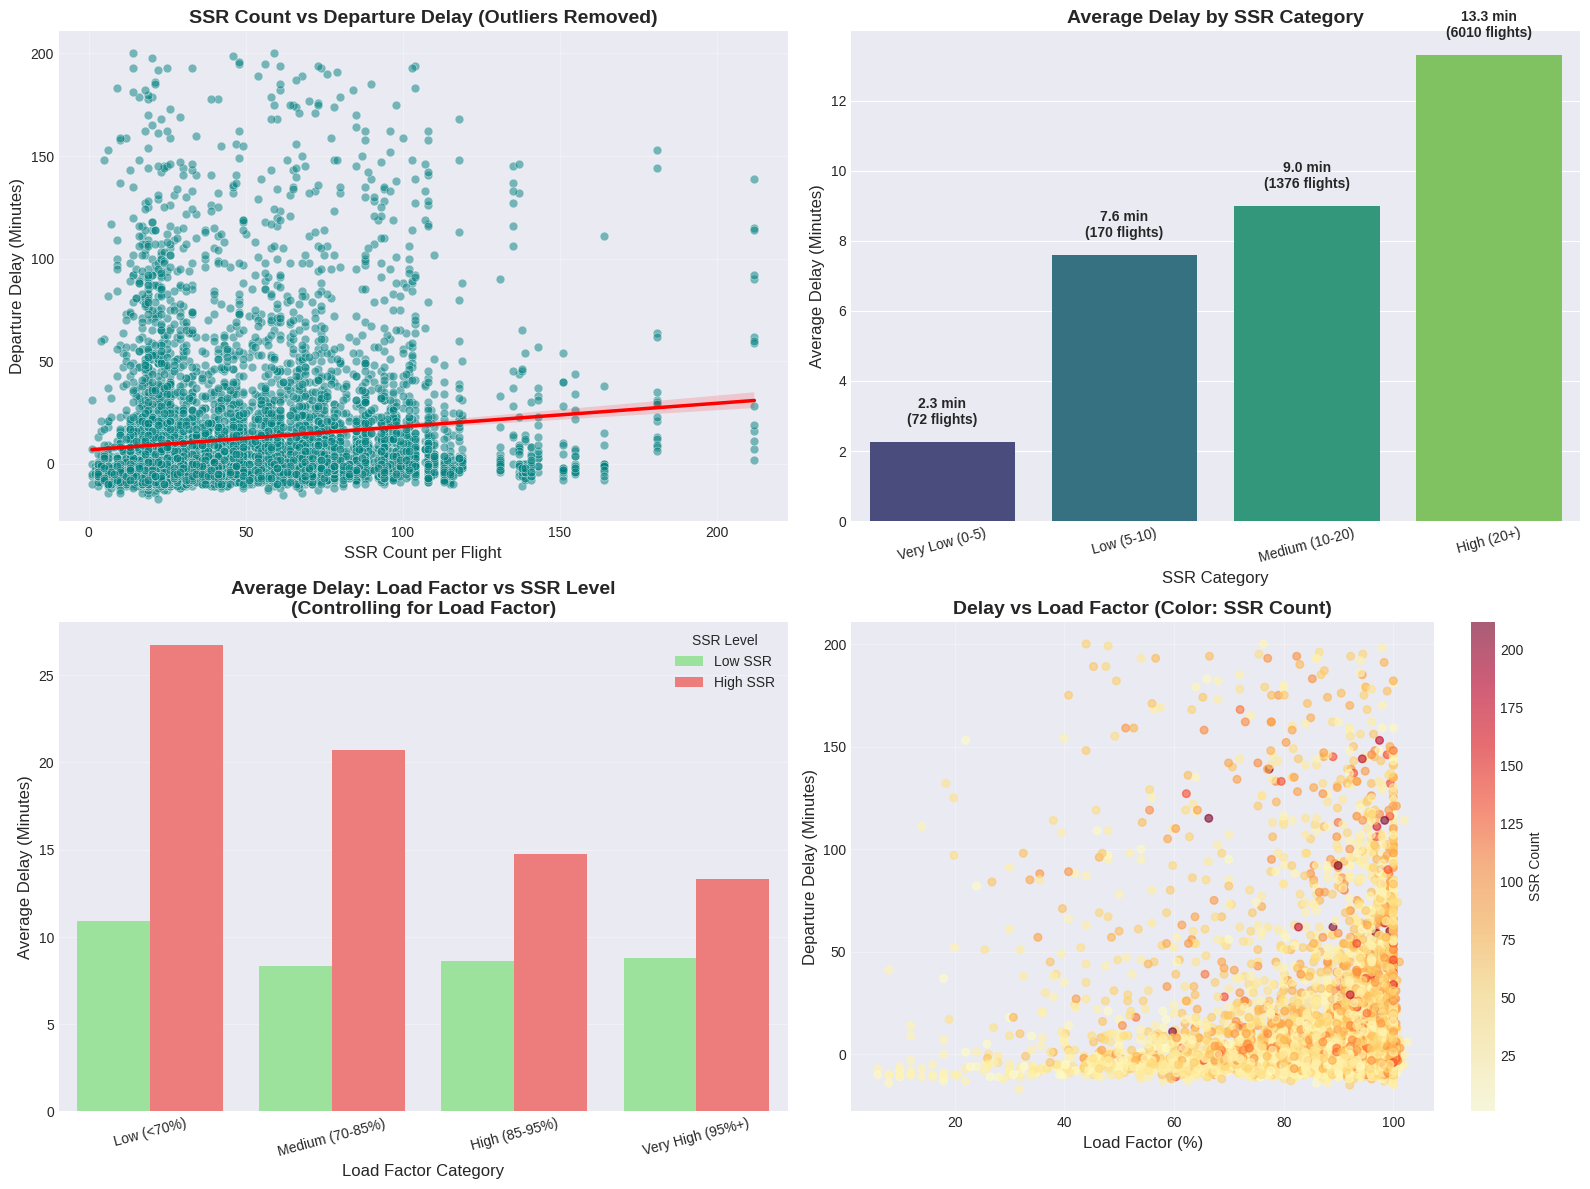


CORRELATION ANALYSIS

Bivariate Correlations:
  SSR Count vs Delay:        +0.1156
  Load Factor vs Delay:      -0.0559  ← (negative = more load, less delay)
  SSR Count vs Load Factor:  +0.1404

Partial Correlation:
  SSR vs Delay (controlling for Load): +0.1249

INTERPRETATION:
WITHOUT controlling for load: SSR has +0.1156 correlation with delay
AFTER controlling for load:   SSR has +0.1249 correlation with delay

Change: +0.0093

✓ The SSR effect INCREASED after controlling for load factor!
  This means: High SSR flights tend to have LOWER load factors,
  which was masking the true SSR-delay relationship.

CONCLUSION:
✓ YES - High SSR flights show HIGHER delays even after controlling
  for load factor (partial correlation = +0.1249)

  This means SSR has an INDEPENDENT effect on delays, separate from
  the load factor effect.

SSR Type Distribution:
  • Airport Wheelchair: 45,738
  • Manual Wheelchair: 3,641
  • Unaccompanied Minor: 1,706
  • Electric Wheelchair: 613


In [298]:
# count of the SSR per flight
ssr_by_flight = (
    pnr_remark_level.groupby('flight_number')
    .size()
    .reset_index(name='ssr_count')
)

# Merge SSR with flight_level data
flight_with_ssr = flight_level.merge(ssr_by_flight, on='flight_number', how='left')
flight_with_ssr['ssr_count'] = flight_with_ssr['ssr_count'].fillna(0)

# NEW: Merge with flight_data to get load_factor
flight_with_ssr = flight_with_ssr.merge(
    flight_data[['company_id', 'flight_number', 'scheduled_departure_date_local', 'load_factor']],
    on=['company_id', 'flight_number', 'scheduled_departure_date_local'],
    how='left'
)

# removed Extreme Outliers
original_count = len(flight_with_ssr)
flight_with_ssr = flight_with_ssr[flight_with_ssr['delay_minutes'] <= 200].copy()
removed_count = original_count - len(flight_with_ssr)
print(f"Removed {removed_count:,} extreme outlier flights (delay > 200 min)")

# Create SSR categories
flight_with_ssr['ssr_category'] = pd.cut(
    flight_with_ssr['ssr_count'],
    bins=[0, 5, 10, 20, float('inf')],
    labels=['Very Low (0-5)', 'Low (5-10)', 'Medium (10-20)', 'High (20+)']
)

# ===== Control for Load Factor =====
# Create Load Factor categories
flight_with_ssr['load_category'] = pd.cut(
    flight_with_ssr['load_factor'],
    bins=[0, 70, 85, 95, 100],
    labels=['Low (<70%)', 'Medium (70-85%)', 'High (85-95%)', 'Very High (95%+)']
)

# Create binary SSR indicator (High vs Low)
ssr_median = flight_with_ssr['ssr_count'].median()
flight_with_ssr['high_ssr'] = flight_with_ssr['ssr_count'] > ssr_median

# Analysis: Average delay by Load Factor and SSR level
delay_by_load_ssr = flight_with_ssr.groupby(['load_category', 'high_ssr'], observed=True).agg({
    'delay_minutes': ['mean', 'count']
}).reset_index()
delay_by_load_ssr.columns = ['Load Category', 'High SSR', 'Avg Delay', 'Count']
delay_by_load_ssr['High SSR'] = delay_by_load_ssr['High SSR'].map({True: 'High SSR', False: 'Low SSR'})

print("\n" + "="*70)
print("AVERAGE DELAY BY LOAD FACTOR AND SSR LEVEL (Controlling for Load)")
print("="*70)
print(f"Note: SSR median = {ssr_median:.1f}, High SSR = flights with >{ssr_median:.1f} SSRs\n")

for load_cat in ['Low (<70%)', 'Medium (70-85%)', 'High (85-95%)', 'Very High (95%+)']:
    if load_cat in delay_by_load_ssr['Load Category'].values:
        print(f"\n{load_cat}:")
        subset = delay_by_load_ssr[delay_by_load_ssr['Load Category'] == load_cat]
        for _, row in subset.iterrows():
            print(f"  {row['High SSR']:12s}: {row['Avg Delay']:6.2f} min (n={int(row['Count']):,} flights)")

# Calculate the SSR effect within each load category
print("\n" + "="*70)
print("SSR IMPACT ON DELAY WITHIN EACH LOAD CATEGORY")
print("(This shows the PURE SSR effect after controlling for load)")
print("="*70)

total_ssr_effect = 0
valid_categories = 0

for load_cat in ['Low (<70%)', 'Medium (70-85%)', 'High (85-95%)', 'Very High (95%+)']:
    if load_cat in delay_by_load_ssr['Load Category'].values:
        subset = delay_by_load_ssr[delay_by_load_ssr['Load Category'] == load_cat]
        if len(subset) == 2:
            high_ssr_delay = subset[subset['High SSR'] == 'High SSR']['Avg Delay'].values[0]
            low_ssr_delay = subset[subset['High SSR'] == 'Low SSR']['Avg Delay'].values[0]
            diff = high_ssr_delay - low_ssr_delay
            total_ssr_effect += diff
            valid_categories += 1
            print(f"{load_cat:20s}: High SSR adds {diff:+6.2f} minutes")

if valid_categories > 0:
    avg_ssr_effect = total_ssr_effect / valid_categories
    print(f"\n{'Average SSR Effect':20s}: {avg_ssr_effect:+6.2f} minutes across all load levels")
print("="*70 + "\n")

# Visualization 
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. SSR Count vs Delay 
sns.scatterplot(
    data=flight_with_ssr,
    x='ssr_count',
    y='delay_minutes',
    alpha=0.5,
    color='teal',
    s=40,
    ax=axes[0, 0]
)
sns.regplot(
    data=flight_with_ssr,
    x='ssr_count',
    y='delay_minutes',
    scatter=False,
    color='red',
    line_kws={'linewidth': 2.5},
    ax=axes[0, 0],
)
axes[0, 0].set_title('SSR Count vs Departure Delay (Outliers Removed)', 
                  fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('SSR Count per Flight', fontsize=12)
axes[0, 0].set_ylabel('Departure Delay (Minutes)', fontsize=12)
axes[0, 0].grid(True, alpha=0.3)

# 2. Average Delay by SSR Category
avg_delay_by_category = flight_with_ssr.groupby('ssr_category', observed=True)['delay_minutes'].agg(['mean', 'count']).reset_index()
avg_delay_by_category.columns = ['SSR Category', 'Avg Delay', 'Flight Count']

sns.barplot(
    data=avg_delay_by_category,
    x='SSR Category',
    y='Avg Delay',
    hue='SSR Category',
    palette='viridis',
    legend=False,
    ax=axes[0, 1]
)
axes[0, 1].set_title('Average Delay by SSR Category', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('SSR Category', fontsize=12)
axes[0, 1].set_ylabel('Average Delay (Minutes)', fontsize=12)
axes[0, 1].tick_params(axis='x', rotation=15)

for i, row in avg_delay_by_category.iterrows():
    axes[0, 1].text(i, row['Avg Delay'] + 0.5, 
                f"{row['Avg Delay']:.1f} min\n({int(row['Flight Count'])} flights)", 
                ha='center', fontweight='bold', fontsize=10)

# 3. Delay by Load Factor and SSR Level (Grouped Bar Chart)
sns.barplot(
    data=delay_by_load_ssr,
    x='Load Category',
    y='Avg Delay',
    hue='High SSR',
    palette=['#90EE90', '#FF6B6B'],  # Light green for Low SSR, Red for High SSR
    ax=axes[1, 0]
)
axes[1, 0].set_title('Average Delay: Load Factor vs SSR Level\n(Controlling for Load Factor)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Load Factor Category', fontsize=12)
axes[1, 0].set_ylabel('Average Delay (Minutes)', fontsize=12)
axes[1, 0].tick_params(axis='x', rotation=15)
axes[1, 0].legend(title='SSR Level', fontsize=10)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Scatter plot with Load Factor colored by SSR level
scatter = axes[1, 1].scatter(
    flight_with_ssr['load_factor'],
    flight_with_ssr['delay_minutes'],
    c=flight_with_ssr['ssr_count'],
    cmap='YlOrRd',
    alpha=0.6,
    s=30
)
axes[1, 1].set_title('Delay vs Load Factor (Color: SSR Count)', 
                     fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Load Factor (%)', fontsize=12)
axes[1, 1].set_ylabel('Departure Delay (Minutes)', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('SSR Count', fontsize=10)

plt.tight_layout()
plt.show()

# Correlations Analysis
print("\n" + "="*70)
print("CORRELATION ANALYSIS")
print("="*70)

# Overall correlations
analysis_df = flight_with_ssr[['ssr_count', 'delay_minutes', 'load_factor']].dropna()

corr_ssr_delay = analysis_df['ssr_count'].corr(analysis_df['delay_minutes'])
corr_load_delay = analysis_df['load_factor'].corr(analysis_df['delay_minutes'])
corr_ssr_load = analysis_df['ssr_count'].corr(analysis_df['load_factor'])

print(f"\nBivariate Correlations:")
print(f"  SSR Count vs Delay:        {corr_ssr_delay:+.4f}")
print(f"  Load Factor vs Delay:      {corr_load_delay:+.4f}  ← (negative = more load, less delay)")
print(f"  SSR Count vs Load Factor:  {corr_ssr_load:+.4f}")

# Partial correlation: SSR and Delay controlling for Load Factor
from scipy import stats

def partial_corr(data, x, y, z):
    """Calculate partial correlation between x and y controlling for z"""
    # Residuals of x regressed on z
    x_resid = data[x] - (stats.linregress(data[z], data[x]).intercept + 
                         stats.linregress(data[z], data[x]).slope * data[z])
    # Residuals of y regressed on z
    y_resid = data[y] - (stats.linregress(data[z], data[y]).intercept + 
                         stats.linregress(data[z], data[y]).slope * data[z])
    # Correlation of residuals
    return stats.pearsonr(x_resid, y_resid)[0]

partial_corr_value = partial_corr(analysis_df, 'ssr_count', 'delay_minutes', 'load_factor')
print(f"\nPartial Correlation:")
print(f"  SSR vs Delay (controlling for Load): {partial_corr_value:+.4f}")

print("\n" + "="*70)
print("INTERPRETATION:")
print("="*70)
print(f"WITHOUT controlling for load: SSR has {corr_ssr_delay:+.4f} correlation with delay")
print(f"AFTER controlling for load:   SSR has {partial_corr_value:+.4f} correlation with delay")
print(f"\nChange: {partial_corr_value - corr_ssr_delay:+.4f}")

if partial_corr_value > corr_ssr_delay:
    print("\n✓ The SSR effect INCREASED after controlling for load factor!")
    print("  This means: High SSR flights tend to have LOWER load factors,")
    print("  which was masking the true SSR-delay relationship.")
else:
    print("\n→ The SSR effect slightly decreased but remains positive.")
    print("  This means: Some of the SSR-delay correlation was due to load,")
    print("  but SSR still independently contributes to delays.")

print("\n" + "="*70)
print("CONCLUSION:")
print("="*70)
if partial_corr_value > 0.05:
    print(f"✓ YES - High SSR flights show HIGHER delays even after controlling")
    print(f"  for load factor (partial correlation = {partial_corr_value:+.4f})")
    print(f"\n  This means SSR has an INDEPENDENT effect on delays, separate from")
    print(f"  the load factor effect.")
else:
    print(f"✗ NO - SSR effect on delay is minimal after controlling for load")
    print(f"  (partial correlation = {partial_corr_value:+.4f})")
print("="*70)

# SSR type distribution
print("\nSSR Type Distribution:")
ssr_type_counts = pnr_remark_level['special_service_request'].value_counts()
for ssr_type, count in ssr_type_counts.items():
    print(f"  • {ssr_type}: {count:,}")

In [270]:
pnr_remark_level

,record_locator,pnr_creation_date,flight_number,special_service_request
0,PNR_153489,2025-07-04,308,Airport Wheelchair
1,PNR_153489,2025-07-04,2182,Airport Wheelchair
2,PNR_153508,2025-07-10,2649,Airport Wheelchair
3,PNR_153508,2025-07-10,2100,Airport Wheelchair
4,PNR_153521,2025-03-01,970,Unaccompanied Minor
...,...,...,...,...
51693,PNR_610754,2025-03-16,9,Airport Wheelchair
51694,PNR_610754,2025-03-16,12,Airport Wheelchair
51695,PNR_610754,2025-03-16,4784,Airport Wheelchair
51696,PNR_610754,2025-03-16,5382,Airport Wheelchair


In [187]:
bag_summary

,company_id,flight_number,scheduled_departure_date_local,scheduled_departure_station_code,scheduled_arrival_station_code,total_bags,transfer_bags,checked_bags,transfer_ratio,transfer_category
0,4Y,52,2025-08-08,ORD,MSP,1,1,0,1.000000,High (>50%)
1,9X,305,2025-08-01,ORD,PIT,1,1,0,1.000000,High (>50%)
2,9X,305,2025-08-08,ORD,PIT,1,1,0,1.000000,High (>50%)
3,9X,330,2025-08-03,ORD,IAD,1,1,0,1.000000,High (>50%)
4,9X,332,2025-08-01,ORD,IAD,1,1,0,1.000000,High (>50%)
...,...,...,...,...,...,...,...,...,...,...
10858,YX,3718,2025-08-10,ORD,MSN,57,50,7,0.877193,High (>50%)
10859,YX,3718,2025-08-11,ORD,MSN,57,57,0,1.000000,High (>50%)
10860,YX,3718,2025-08-12,ORD,MSN,34,32,2,0.941176,High (>50%)
10861,YX,3718,2025-08-14,ORD,MSN,50,48,2,0.960000,High (>50%)
